## scikeras Keras regressor integration

The integration of KerasRegressor in pipeline is limited. To use full keras capabilities, you may need to modify the pipeline.

In [7]:
# Standard loading and preprocessing code

from pinard import nirs_set as n_set
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
import random

# Init basic random
rd_seed = 42
np.random.seed(rd_seed)
tf.random.set_seed(rd_seed)
random.seed(rd_seed)
# tf.config.experimental.enable_op_determinism()
# tf.config.experimental.disable_op_determinism()




# Create a set named data
n = n_set.NIRS_Set('data')

# Load csv data and split into train and test
# X, y = n.load('Xcal.csv', 'Ycal.csv', x_hdr=0, y_hdr=0, y_cols=0)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = rd_seed)


# X_train, y_train = n.load('Xcal (7).csv', 'Ycal (7).csv', x_hdr=0, y_hdr=0, y_cols=0)
# X_test, y_test = n.load('Xval (7).csv', 'Yval (7).csv', x_hdr=0, y_hdr=0, y_cols=0)

# X_train, y_train = n.load('Xcal (8).csv', 'Ycal (8).csv', x_hdr=0, y_hdr=0, y_cols=0)
# X_test, y_test = n.load('Xval (8).csv', 'Yval (8).csv', x_hdr=0, y_hdr=0, y_cols=0)

# X_train, y_train = n.load('gilles/Xcal.csv', 'gilles/Ycal.csv', y_cols=0)
# X_test, y_test = n.load('gilles/Xval.csv', 'gilles/Yval.csv', y_cols=0)

# path = "benchmark/regression/LUCAS_SOCgrassland_4096_Nocita_RMSE7.2"
path = "benchmark/regression/ALPINE_Calpine_424_Murguzur_RMSE1.36"
X_train, y_train = n.load(path + '/Xcal.csv', path + '/Ycal.csv', y_cols=0, x_hdr=0, y_hdr=0)
X_test, y_test = n.load(path + '/Xval.csv', path + '/Yval.csv', y_cols=0, x_hdr=0, y_hdr=0)


print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


from pinard import preprocessor as pp
from sklearn.pipeline import Pipeline
    # "Baseline", 
    # "StandardNormalVariate", ## SAME as STANDARDSCALER
    # "RobustNormalVariate", ## SAME as ROBUSTSCALER
    # "SavitzkyGolay",
    # "Normalize",
    # "Detrend",
    # "MultiplicativeScatterCorrection",
    # "Derivate",
    # "Gaussian",
    # "Wavelet",
    # "SimpleScale",


### Declare preprocessing pipeline components
preprocessing = [   ('id', pp.IdentityTransformer()),
                    ('baseline', pp.StandardNormalVariate()),
                    ('savgol', pp.SavitzkyGolay()),
                    ('gaussian1', pp.Gaussian(order = 1, sigma = 2)),
                    ('gaussian2', pp.Gaussian(order = 2, sigma = 1)),
                    ('haar', pp.Wavelet('haar')),
                    ('coif3', pp.Wavelet('coif3')),
                    ('detrend', pp.Detrend()),
                    ('msc', pp.MultiplicativeScatterCorrection(scale=False)),
                    ('dv1', pp.Derivate(1,1)),
                    ('dv2', pp.Derivate(2,1)),
                    ('dv3', pp.Derivate(2,2)),
                    
                    ('baseline*savgol', Pipeline([('_sg1',pp.StandardNormalVariate()),('_sg2',pp.SavitzkyGolay())])),
                    ('baseline*gaussian1', Pipeline([('_sg1',pp.StandardNormalVariate()),('g2', pp.Gaussian(order = 1, sigma = 2) )])),
                    ('baseline*gaussian2', Pipeline([('_sg1',pp.StandardNormalVariate()),('g2', pp.Gaussian(order = 2, sigma = 1) )])),
                    ('baseline*haar', Pipeline([('_sg1',pp.StandardNormalVariate()),('_sg2',pp.Wavelet('haar'))])),
                    
                    # ('savgol*savgol', Pipeline([('_sg1',pp.SavitzkyGolay()),('_sg2',pp.SavitzkyGolay())])),
                    # ('savgol*baseline', Pipeline([('_sg1',pp.SavitzkyGolay()),('_sg2',pp.StandardNormalVariate())])),
                    ('savgol*gaussian1', Pipeline([('_sg1',pp.SavitzkyGolay()),('g2', pp.Gaussian(order = 1, sigma = 2) )])),
                    ('savgol*gaussian2', Pipeline([('_sg1',pp.SavitzkyGolay()),('g2', pp.Gaussian(order = 2, sigma = 1) )])),
                    # ('savgol*haar', Pipeline([('_sg1',pp.SavitzkyGolay()), ('haar', pp.Wavelet('haar'))])),
                    # ('gaussian1*savgol', Pipeline([('_g1',pp.Gaussian(order = 1, sigma = 2)),('_sg3',pp.SavitzkyGolay())])),
                    ('gaussian2*savgol', Pipeline([('_g2',pp.Gaussian(order = 1, sigma = 2)),('_sg4',pp.SavitzkyGolay())])),
                    # ('haar*savgol', Pipeline([('_haar2',pp.Wavelet('haar')),('_sg5',pp.SavitzkyGolay())])),
                    # ('haar*gaussian1', Pipeline([('_haar2',pp.Wavelet('haar')), ('g2', pp.Gaussian(order = 1, sigma = 2)) ])),
                    ('haar*gaussian2', Pipeline([('_haar2',pp.Wavelet('haar')), ('g2', pp.Gaussian(order = 2, sigma = 1)) ])),
                ]

(272, 2151) (272,) (152, 2151) (152,)


## Complex pipeline

In the following example we will declare a custom callback, un custom optimizer and we will use test data as validation metrics for the keras model.

### Custom Adam optimizer with Cyclic Learning Rate

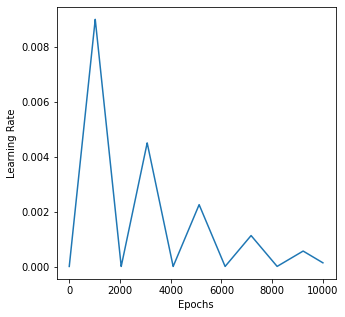

In [15]:
from tensorflow_addons.optimizers import CyclicalLearningRate
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

BATCH_SIZE = 192
EPOCHS = 10000
# MIN_LR = 5e-7
# MAX_LR = 1e-3

MIN_LR = 2e-5
MAX_LR = 9e-3
CYCLE_LENGTH = 1024

steps_per_epoch = len(X_train) // BATCH_SIZE

# Define the learning rate cycle properties
clr = CyclicalLearningRate(
    initial_learning_rate=MIN_LR,
    maximal_learning_rate=MAX_LR,
    scale_fn=lambda x: 1/(2.**(x-1)),
    step_size= CYCLE_LENGTH * steps_per_epoch
)

optimizer = Adam(clr)
# optimizer = Adadelta(clr)

# Display learning rate evolution
epochs = np.arange(0, EPOCHS)
lr = clr(steps_per_epoch * epochs)
plt.plot(epochs, lr)
plt.rcParams["figure.figsize"] = (3,6)
plt.xlabel("Epochs")
plt.ylabel("Learning Rate")
plt.show()

### Custom callback

We define a custom callback that store the current best model weights.

In [3]:
from tensorflow.keras.callbacks import Callback

# custom Keras Callback that store 
class Auto_Save(Callback):
    best_weights = []
    def __init__(self):
        super(Auto_Save, self).__init__()
        self.best = np.Inf
                
    def on_epoch_end(self, epoch, logs=None):
        current_loss = logs.get('val_loss')
        if np.less(current_loss, self.best):
            self.best = current_loss            
            Auto_Save.best_weights = self.model.get_weights()
            print("Best so far >", self.best)
            
    def on_train_end(self, logs=None):
        if self.params['verbose'] == 2:
            print('\nSaved best {0:6.4f}\n'.format(self.best))

### Custom callback to display Learning rate during training

We define a custom callback to display the evolution of the learning rate

In [4]:

class Print_LR(Callback):    
    def on_epoch_end(self, epoch, logs=None):
        iteration = self.model.optimizer.iterations.numpy()
        # lr = clr(iteration).numpy()
        lr = self.model.optimizer.learning_rate
        if self.params['verbose'] == 2:
            print("Iteration {} - Learning rate: {}".format(iteration, lr) )

### Bacon VG

In [41]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Concatenate,GlobalAveragePooling1D, Conv1D, Activation, SpatialDropout1D,SeparableConv1D,Flatten, Dropout, Input, MaxPooling1D, DepthwiseConv1D, BatchNormalization, AveragePooling1D
from typing import Dict, Iterable, Any
from tensorflow.keras.optimizers import Adam, Adadelta

def conv1D_block(model, filters):
    # model.add(SpatialDropout1D(0.2))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=filters, kernel_size=3, padding="same"))
    model.add(Conv1D(filters=filters, kernel_size=3, padding="same"))
    model.add(MaxPooling1D(pool_size=4,strides=2))

def depthconv1D_block(model, filters):
    model.add(BatchNormalization())
    model.add(DepthwiseConv1D(kernel_size=3, depth_multiplier=filters, padding="same", activation='swish'))
    model.add(DepthwiseConv1D(kernel_size=3, depth_multiplier=filters, padding="same", activation='swish'))
    model.add(AveragePooling1D(pool_size=4,strides=2))
    
def sepconv1D_block(model, filters):
    model.add(SpatialDropout1D(0.2))
    model.add(SeparableConv1D(filters, kernel_size=3, depth_multiplier=1, padding="same", activation='swish'))
    model.add(SeparableConv1D(filters, kernel_size=3, depth_multiplier=1, padding="same", activation='swish'))
    model.add(MaxPooling1D(pool_size=5,strides=3))

def keras_model(meta: Dict[str, Any]):
    input_shape = meta["X_shape_"][1:]
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(SpatialDropout1D(0.2))
    # depthconv1D_block(model, 1)
    depthconv1D_block(model, 2)
    depthconv1D_block(model, 4)
    depthconv1D_block(model, 4)
    # model.add(MaxPooling1D(pool_size=2,strides=2))
    model.add(MaxPooling1D(pool_size=2,strides=2))
    sepconv1D_block(model, 128)
    # conv1D_block(model, 128)
    # conv1D_block(model, 16)
    # conv1D_block(model, 256)
    # model.add(MaxPooling1D(pool_size=11,strides=5))
    # depthconv1D_block(model, 256)
    # model.add(BatchNormalization())
    # depthconv1D_block(model, 128)
    # model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(units=256, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(units=128, activation="relu"))
    model.add(Dense(units=1, activation="sigmoid"))
    # we compile the model with the custom Adam optimizer
    model.compile(loss = 'mean_squared_error', metrics=['mse'], optimizer = "adam")
    model.summary()
    return model

In [13]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Concatenate,GlobalAveragePooling1D, Conv1D, Activation, SpatialDropout1D,SeparableConv1D,Flatten, Dropout, Input, MaxPooling1D, DepthwiseConv1D, BatchNormalization, AveragePooling1D
from typing import Dict, Iterable, Any
from tensorflow.keras.optimizers import Adam, Adadelta
import models

# BATCH_SIZE = 128
# EPOCHS = 10000
# # MIN_LR = 5e-7
# # MAX_LR = 1e-3

# MIN_LR = 5e-5
# MAX_LR = 5e-3
# CYCLE_LENGTH = 512

def keras_model(meta: Dict[str, Any]):
    input_shape = meta["X_shape_"][1:]
    # model = models.xception(input_shape)
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(SpatialDropout1D(0.2))
    model.add(DepthwiseConv1D(kernel_size=7, padding="same",depth_multiplier=2, activation='relu'))
    model.add(DepthwiseConv1D(kernel_size=7, padding="same",depth_multiplier=2, activation='relu'))
    model.add(AveragePooling1D(pool_size=2,strides=2))
    model.add(BatchNormalization())
    model.add(DepthwiseConv1D(kernel_size=5, padding="same",depth_multiplier=2, activation='relu'))
    model.add(DepthwiseConv1D(kernel_size=5, padding="same",depth_multiplier=2, activation='relu'))
    model.add(AveragePooling1D(pool_size=2,strides=2))
    model.add(BatchNormalization())
    model.add(DepthwiseConv1D(kernel_size=9, padding="same",depth_multiplier=2, activation='relu'))
    model.add(DepthwiseConv1D(kernel_size=9, padding="same",depth_multiplier=2, activation='relu'))
    model.add(MaxPooling1D(pool_size=2,strides=2))
    model.add(BatchNormalization())
    
    model.add(SeparableConv1D(128, kernel_size=5, depth_multiplier=1, padding="same", activation='relu'))
    model.add(Conv1D(filters=32, kernel_size=3, padding="same"))
    model.add(MaxPooling1D(pool_size=5,strides=3))
    model.add(SpatialDropout1D(0.2))
    model.add(Flatten())
    model.add(Dense(units=128, activation="relu"))
    model.add(Dense(units=32, activation="relu"))
    model.add(Dropout(0.1))
    model.add(Dense(units=1, activation="sigmoid"))
    # # optimizer = Adadelta(learning_rate=1.0, rho=0.95, epsilon=1e-07)
    # model.compile(loss = 'mean_squared_error', metrics=['mse'], optimizer = optimizer)
    model.compile(loss = 'mean_squared_error', metrics=['mse'], optimizer = "adam")
    model.summary()
    return model

## Complex pipeline

In this pipeline we decompose transformers and estimators to be able to use custom validation data in the fitting process

In [16]:


from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import datetime
from pinard.nirs_pipelines import FeatureAugmentation

from scikeras.wrappers import KerasRegressor

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import math

# Y scaler to scale test data set to create Y validation data
y_scaler = MinMaxScaler()
y_scaler.fit(y_train.reshape((-1,1)))
y_valid = y_scaler.transform(y_test.reshape((-1,1)))
    

# X transformation pipeline to create X validation data
transformer_pipeline = Pipeline([
    ('scaler', MinMaxScaler()), 
    ('preprocessing', FeatureAugmentation(preprocessing)), 
])

## we could have used a full standard pipeline and access transformers with:
## estimator.regressor_[:-1].transform(X_test)
transformer_pipeline.fit(X_train)
X_valid = transformer_pipeline.transform(X_test)

# KerasRegressor definition, with validation data and callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=1000, verbose=0, mode='min') 
# reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=100, verbose=1, epsilon=0.5e-5, mode='min')
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


k_regressor = KerasRegressor(model = keras_model,
                            callbacks=[Auto_Save(), Print_LR(), early_stop, tensorboard_callback],
                            epochs=10000,
                            # random_state = rd_seed,
                            fit__batch_size=BATCH_SIZE,
                            fit__validation_data = (X_valid, y_valid),
                            verbose = 2)

# estimation pipeline
pipeline = Pipeline([
    ('trans', transformer_pipeline), 
    ('KerasNN', k_regressor)
])

estimator = TransformedTargetRegressor(regressor = pipeline, transformer = y_scaler)
estimator.fit(X_train, y_train)

# We update the keras model to the saved weights (note the use of _ for regressor and model)
estimator.regressor_[1].model_.set_weights(Auto_Save.best_weights)

Y_preds = estimator.predict(X_test)
print("MAE", mean_absolute_error(y_test, Y_preds))
print("MSE", mean_squared_error(y_test, Y_preds))
print("RMSE", math.sqrt(mean_squared_error(y_test, Y_preds)))
print("MAPE", mean_absolute_percentage_error(y_test, Y_preds))
print("R²", r2_score(y_test, Y_preds))

plt.rcParams["figure.figsize"] = (5,5)
plt.plot(Y_preds, y_test, 'ro', alpha=0.4, markersize=3)
plt.xlabel('predicted')
plt.ylabel('observed')
plt.show()


TRANSFORM
ahahah (152, 2151, 20)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 spatial_dropout1d_10 (Spati  (None, 2151, 20)         0         
 alDropout1D)                                                    
                                                                 
 depthwise_conv1d_30 (Depthw  (None, 2151, 40)         320       
 iseConv1D)                                                      
                                                                 
 depthwise_conv1d_31 (Depthw  (None, 2151, 80)         640       
 iseConv1D)                                                      
                                                                 
 average_pooling1d_10 (Avera  (None, 1075, 80)         0         
 gePooling1D)                                                    
                                                                 
 batch_normalization_

KeyboardInterrupt: 

### XCeption 1D

In [ ]:
xception = models.xception((256,3))
xception.compile(optimizer='adam', 
                 loss='mean_squared_error', 
                 metrics=['mae','mse'])

# plot_model(xception, to_file='model.png', show_shapes=True, show_layer_names=True)
history = xception.fit(X_trainEff, 
                       y_trainEff, 
                       epochs=200, 
                       batch_size=64,
                       callbacks=[Auto_Save()],
                       validation_data=(X_valid, y_valid))
# Predict test fold
xception.set_weights(Auto_Save.best_weights)
Y_preds = xception.predict(X_valid)
Y_preds = y_scaler.inverse_transform(Y_preds)
print("MAE", mean_absolute_error(y_test, Y_preds))
print("MSE", mean_squared_error(y_test, Y_preds))
print("RMSE", math.sqrt(mean_squared_error(y_test, Y_preds)))
print("MAPE", mean_absolute_percentage_error(y_test, Y_preds))
print("R²", r2_score(y_test, Y_preds))

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6,6)
plt.plot(Y_preds, y_test, 'ro', alpha=0.4, markersize=5)
plt.xlabel('predicted')
plt.ylabel('observed')
plt.show()



## Cross validation with Keras Regressor

sklearn cv_validation does not consider the best version of the keras regressor.
The following example handles the problem.

In [ ]:
from sklearn.model_selection import RepeatedKFold

kfold = RepeatedKFold(n_splits= 4, n_repeats= 2, random_state=rd_seed)

fold = 0
for train, test in kfold.split(y):
    X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]
    
    # prepare validation data
    y_scaler = MinMaxScaler()
    y_scaler.fit(y_train.reshape((-1,1)))
    y_valid = y_scaler.transform(y_test.reshape((-1,1)))
    transformer_pipeline.fit(X_train)
    X_valid = transformer_pipeline.transform(X_test)
    
    # declare and fit regressor    
    k_regressor = KerasRegressor(model = keras_model,
                            callbacks=[Auto_Save(), Print_LR(), early_stop],
                            epochs=EPOCHS, 
                            fit__batch_size=BATCH_SIZE,
                            fit__validation_data = (X_valid, y_valid),
                            verbose = 0)

    pipeline = Pipeline([
        ('trans', transformer_pipeline), 
        ('KerasNN', k_regressor)
    ])

    estimator = TransformedTargetRegressor(regressor = pipeline, transformer = y_scaler)
    estimator.fit(X_train, y_train)
    
    # Predict test fold
    estimator.regressor_[1].model_.set_weights(Auto_Save.best_weights)
    Y_preds = estimator.predict(X_test)
    
    print("Fold:", fold, "- MSE:", mean_squared_error(y_test, Y_preds), "- R²:", r2_score(y_test, Y_preds))
    fold += 1

In [1]:
from numba import cuda

def clear_gpu():
    device = cuda.get_current_device()
    device.reset()
    
clear_gpu()